In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from wordcloud  import WordCloud

plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# 获取当前路径文件
for root, _ , files in os.walk('./dataset'):
    for filename in files:
        print(os.path.join(root, filename))

./dataset\arxiv-metadata-oai-snapshot.json
./dataset\dataNear.csv
./dataset\dataNoDet.csv
./dataset\dataTaxonomy.csv


In [3]:
# 读取近3年元数据
paperData = pd.read_csv("./dataset/dataNear.csv")
paperData.info()

E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536847 entries, 0 to 536846
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              536847 non-null  object
 1   submitter       536714 non-null  object
 2   authors         536847 non-null  object
 3   title           536847 non-null  object
 4   comments        369603 non-null  object
 5   journal-ref     143937 non-null  object
 6   doi             208892 non-null  object
 7   report-no       17807 non-null   object
 8   categories      536847 non-null  object
 9   license         532750 non-null  object
 10  abstract        536847 non-null  object
 11  versions        536847 non-null  object

In [4]:
# 读取分类信息数据
dataTaxonomy = pd.read_csv("./dataset/dataTaxonomy.csv")
dataTaxonomy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155 entries, 0 to 154
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   group_name            155 non-null    object
 1   archive_name          155 non-null    object
 2   archive_id            155 non-null    object
 3   category_name         155 non-null    object
 4   categories            155 non-null    object
 5   category_description  155 non-null    object
dtypes: object(6)
memory usage: 7.4+ KB


In [5]:
# 合并元数据+分类数据；
# 直接合并类别项，一条记录的类别可能有多个 
# ==>> data_mulCat [运行需要 20s]
data_mulCat = paperData.merge(dataTaxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]).groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

In [7]:
# 合并元数据+分类数据；
# 合并类别项目，一个子方向生成一条记录 
# ==>> dataOneCtgr [运行需要 20s]
dataOneCtgr = paperData.copy(deep=True)
print("[INFO] 标签不同的paper有：", len(dataOneCtgr.categories.unique()))
tmp = dataOneCtgr.categories.str.split(" ")
dataOneCtgr.categories = tmp

# 炸开categories的列表，复制其它值补全；一个子类对应一条数据
dataOneCtgr = dataOneCtgr.explode("categories").merge(dataTaxonomy, on="categories", how="left").drop_duplicates(["id","group_name"]) 


[INFO] 标签不同的paper有： 33429


In [8]:
# 统计各学科论文数量
dataOneCtgr_coutCtgr = dataOneCtgr.groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

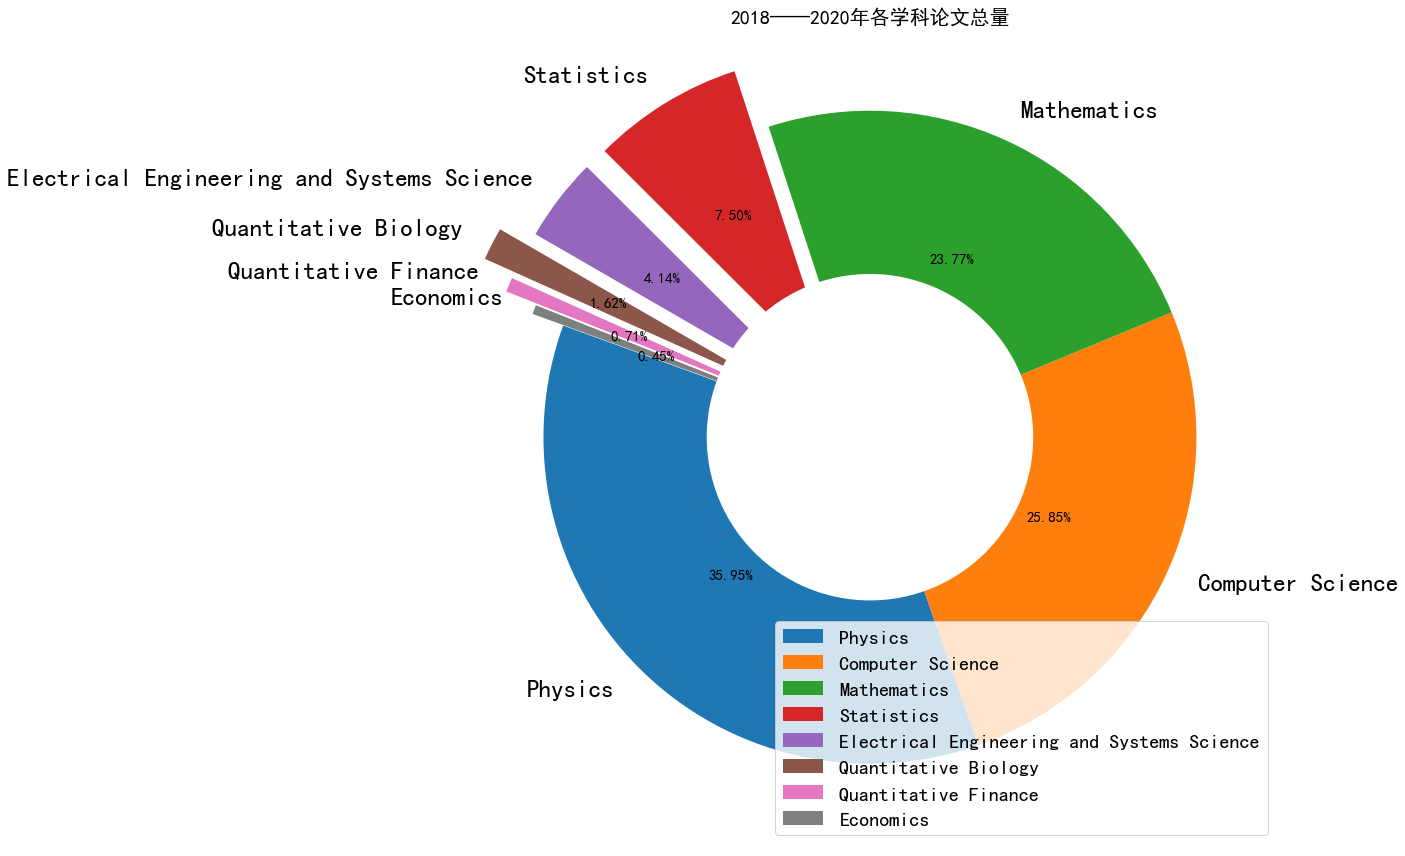

In [9]:
# 用饼图表示近3年各学科发文量
mydf = dataOneCtgr_coutCtgr
fig = plt.figure(figsize=(15,12))
explode = (0, 0, 0, 0.2, 0.2, 0.3, 0.2, 0.1) 
_, l_text, p_text = plt.pie(mydf["id"],  labels=mydf["group_name"], autopct='%1.2f%%', startangle=160, explode=explode)

plt.title("2018——2020年各学科论文总量", fontsize=20)
plt.tight_layout()
plt.legend(fontsize=20, loc="lower right")

for t in l_text:
    t.set_size(25)
for t in p_text:
    t.set_size(15)

x_0 = [1,0,0,0]  # 用于显示空心
plt.pie(x_0, radius=0.5,colors = 'w')

plt.show()

In [10]:
# 统计计算机近3年子方向论文数量
group_name = "Computer Science"
cats = dataOneCtgr.query("group_name == @group_name")
dataNearOneCtgr_countCD = cats.groupby(["year","category_name"]).count().reset_index().pivot(index="category_name", columns="year",values="id").sort_values(by=2020)


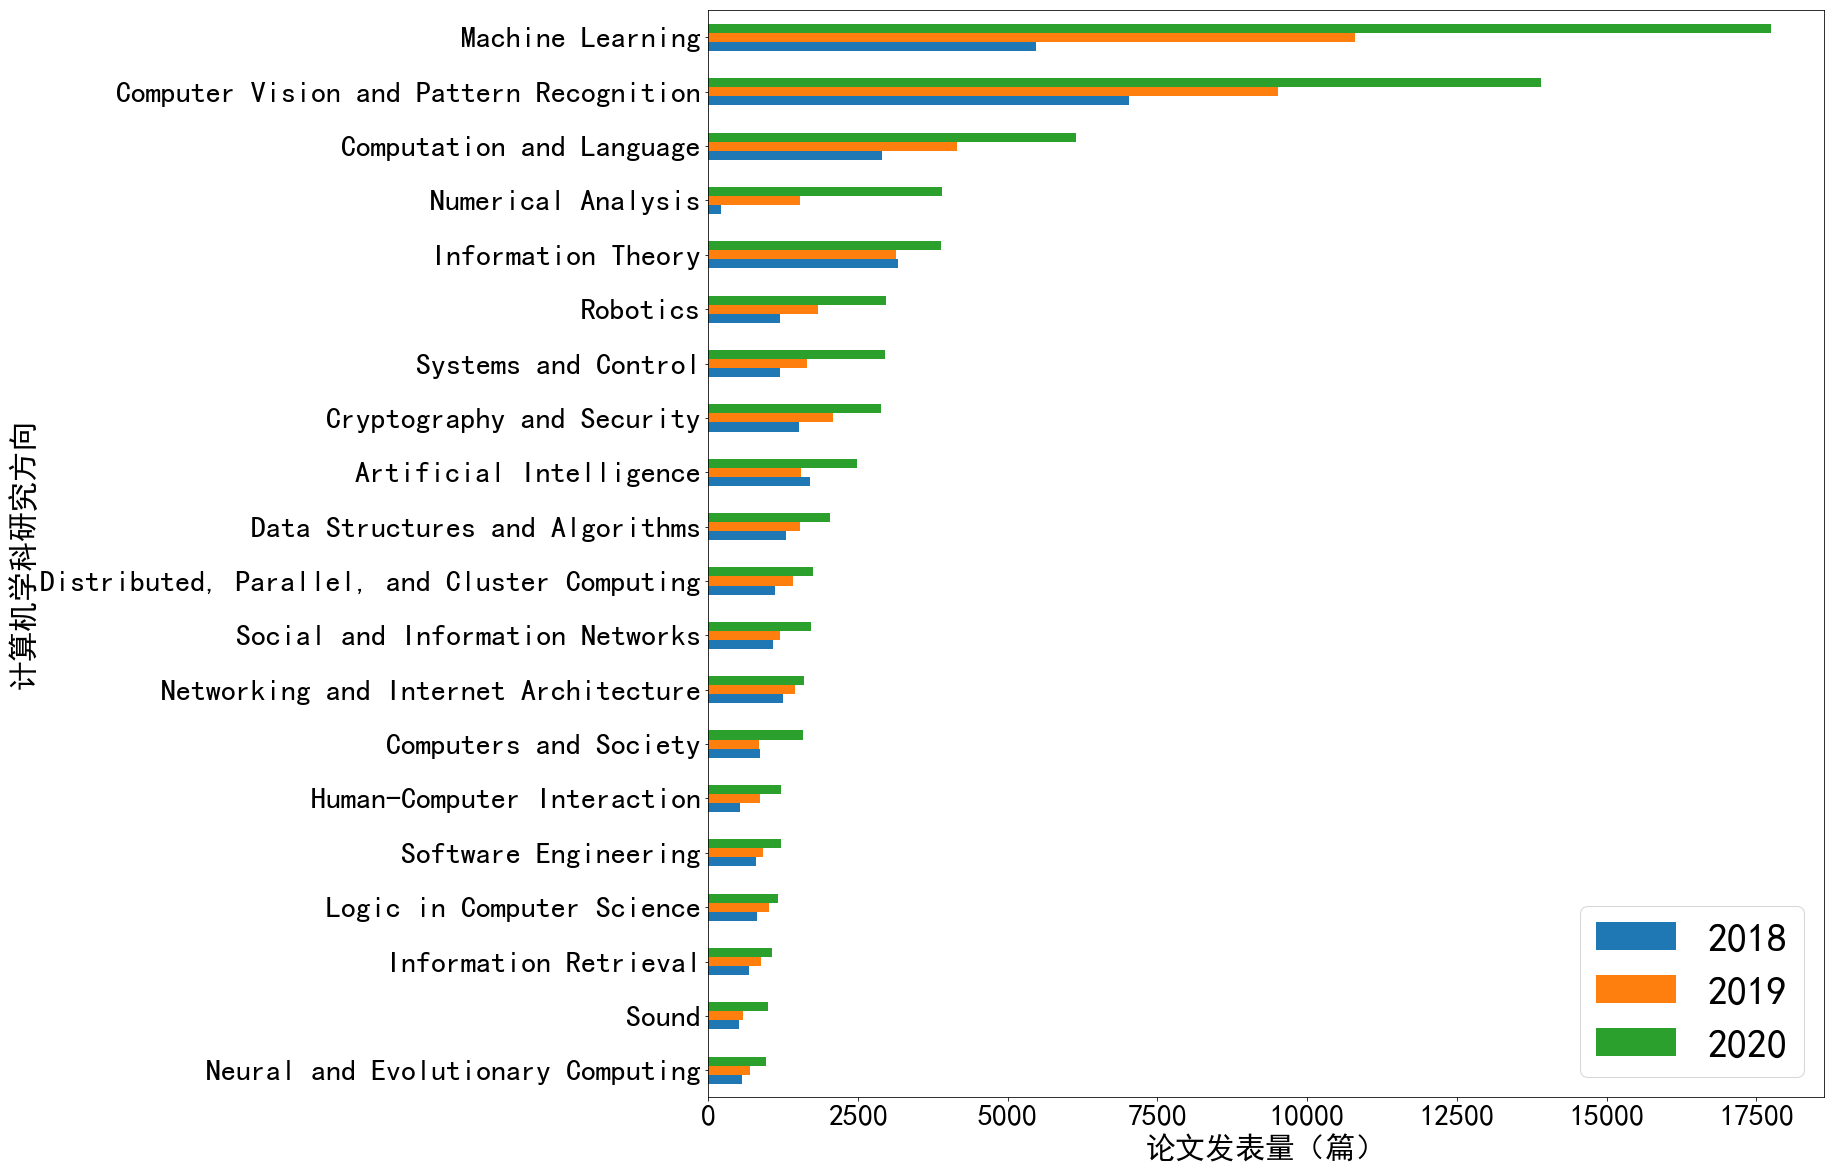

In [11]:
# 多柱状图表示计算机各方向3年论文数量
fig = plt.figure()
ax1  = fig.add_subplot(111)
dataNearOneCtgr_countCD.tail(20).plot(kind='barh', figsize=(20, 20), fontsize=30, ax=ax1)
ax1.set_ylabel('计算机学科研究方向', fontsize=30)
ax1.set_xlabel('论文发表量（篇）', fontsize=30)
plt.legend(fontsize=40)

In [18]:
# 2020年前4个方向论文数量占总数比
print("[INFO] 2020年度CS前四个方向paper数量占比：{a:.2f}%".\
    format(\
        a = dataNearOneCtgr_countCD[2020].sort_values().iloc[-4:].sum() / dataNearOneCtgr_countCD[2020].sort_values().sum() * 100
    )
)

[INFO] 2020年度CS前四个方向paper数量占比：51.88%


################### 2008——2020数据 #############


In [19]:
dataNoDet = pd.read_csv("./dataset/dataNoDet.csv")

E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# 统计每年论文数量
dataNoDet_countY = dataNoDet.groupby("year").agg({"id": "count"})

E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


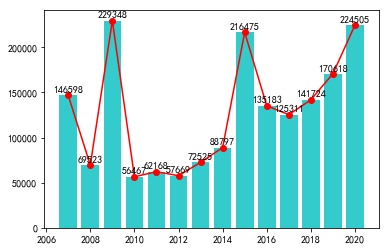

In [21]:
# 每年论文走势折线+柱状图
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(dataNoDet_countY.index, dataNoDet_countY["id"], c='r', marker="o")
ax1.bar(x=dataNoDet_countY.index, height=dataNoDet_countY["id"], color='c', alpha=0.8)
for a,b in zip(dataNoDet_countY.index, dataNoDet_countY["id"]):
    ax1.text(a, b+2000, '%s' % b, ha='center', va= 'bottom', fontsize=10)


In [22]:
# 统计每年每月论文数量
dataNoDet_countYM = dataNoDet.groupby(["month", "year"]).count().reset_index().pivot(index="month", columns="year",values="id").sort_index(ascending=False)
dataNoDet_countYM.describe()

year,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
count,8.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,11.000000
mean,18324.750000,5793.583333,19112.333333,4705.583333,5180.666667,4805.750000,6043.750000,7399.750000,18039.583333,11265.250000,10442.583333,11810.333333,14218.166667,20409.545455
std,45538.671951,9627.969062,35907.993185,1711.308774,799.551844,714.808191,1430.057731,3519.346482,23208.014527,3746.704713,1305.181594,887.327175,1992.288124,3744.931358
min,1779.000000,1866.000000,2878.000000,2932.000000,4117.000000,4177.000000,5087.000000,5407.000000,6039.000000,7952.000000,8960.000000,10664.000000,12049.000000,15495.000000
25%,1868.000000,1947.500000,3732.250000,3480.500000,4360.000000,4379.500000,5388.000000,6146.250000,7023.000000,9218.250000,9620.250000,11123.250000,12927.500000,17967.000000
50%,2180.000000,2326.000000,4047.000000,4399.000000,5386.000000,4596.500000,5724.500000,6314.000000,8258.000000,9533.500000,10289.000000,11718.500000,13534.500000,19503.000000
75%,2758.250000,3365.500000,6279.000000,4720.250000,5743.500000,4910.500000,5910.250000,6699.750000,11158.750000,11477.500000,10795.750000,12583.750000,14718.250000,22431.000000
max,131022.000000,35595.000000,118287.000000,8660.000000,6464.000000,6679.000000,10431.000000,18325.000000,79775.000000,19646.000000,13872.000000,13420.000000,19255.000000,28118.000000


In [23]:
# 删除2007年论文数量记录
dataNoDet_countYM = dataNoDet_countYM.drop(labels=dataNoDet_countYM.columns[0:1], axis=1)

Text(0.5, 0, '论文数量（万篇）')

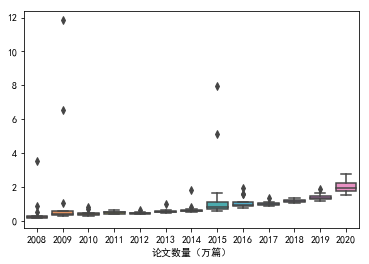

In [24]:
# 2008——2020年论文数量箱线图
sns.boxplot(data= dataNoDet_countYM.iloc[:, :] / 10000, orient="v")
plt.xlabel("论文数量（万篇）")

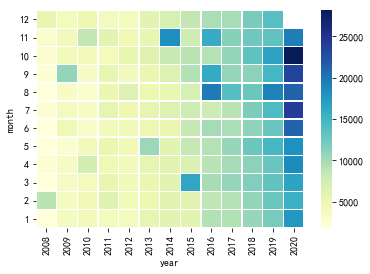

In [25]:
# 各年份月份论文数热力图
dataNoDet_countYM.iloc[6:8, 7] = [np.nan, np.nan]
dataNoDet_countYM.iloc[1:3, 1] = [np.nan, np.nan]
dataNoDet_countYM.iloc[1, 0] = np.nan
dataNoDet_countYM.iloc[6:8, 7] = [int(dataNoDet_countYM[2015].mean())] * 2
dataNoDet_countYM.iloc[1:3, 1] = [int(dataNoDet_countYM[2009].mean())] * 2
dataNoDet_countYM.iloc[1, 0] = int(dataNoDet_countYM[2008].mean())
fig = plt.figure()
ax1 = fig.add_subplot()
ax1 = sns.heatmap(dataNoDet_countYM, cmap="YlGnBu", linewidths=0.5)
plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show() 

In [26]:
# 取2007年以后的记录==>>dataAllOneCtgr
dataAllOneCtgr = dataNoDet[dataNoDet["year"] > 2007]

In [27]:
# 合并元数据+分类数据；
# 合并类别项目，一个方向一条记录
# 运行时间约 20s
tmp = dataAllOneCtgr.categories.str.split(" ")
dataAllOneCtgr.categories = tmp

# 炸开categories的列表，复制其它值补全；一个子类对应一条数据
dataAllOneCtgr = dataAllOneCtgr.explode("categories").merge(dataTaxonomy, on="categories", how="left").drop_duplicates(["id","group_name"])

E:\prjsoftware\anaconda3\envs\python36\lib\site-packages\pandas\core\generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [28]:
# 统计各学科论文数量
dataAllOneCtgr_count = dataAllOneCtgr.groupby("group_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

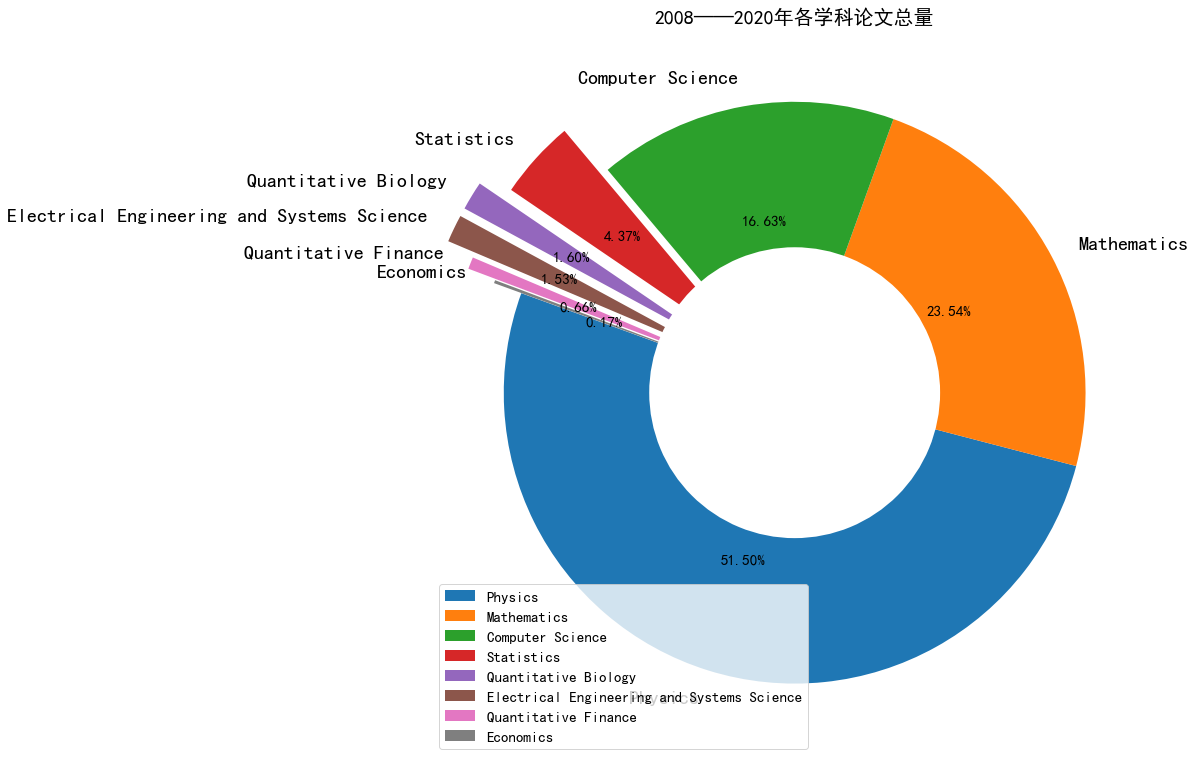

In [29]:
# 用饼图表示所有各学科发文量
mydf = dataAllOneCtgr_count
fig = plt.figure(figsize=(15,12))

explode = (0, 0, 0, 0.2, 0.3, 0.3, 0.2, 0.1) 
_, l_text, p_text = plt.pie(mydf["id"],  labels=mydf["group_name"], autopct='%1.2f%%', startangle=160, explode=explode)
plt.legend(fontsize=15)
plt.title("2008——2020年各学科论文总量", fontsize=20)

for t in l_text:
    t.set_size(20)
for t in p_text:
    t.set_size(15)

x_0 = [1,0,0,0]#用于显示空心
plt.pie(x_0, radius=0.5,colors = 'w')

plt.tight_layout()

In [30]:
# 统计各方向论文数量
dataAllOneCtgr_countD = dataAllOneCtgr.groupby("category_name").agg({"id":"count"}).sort_values(by="id",ascending=False).reset_index()

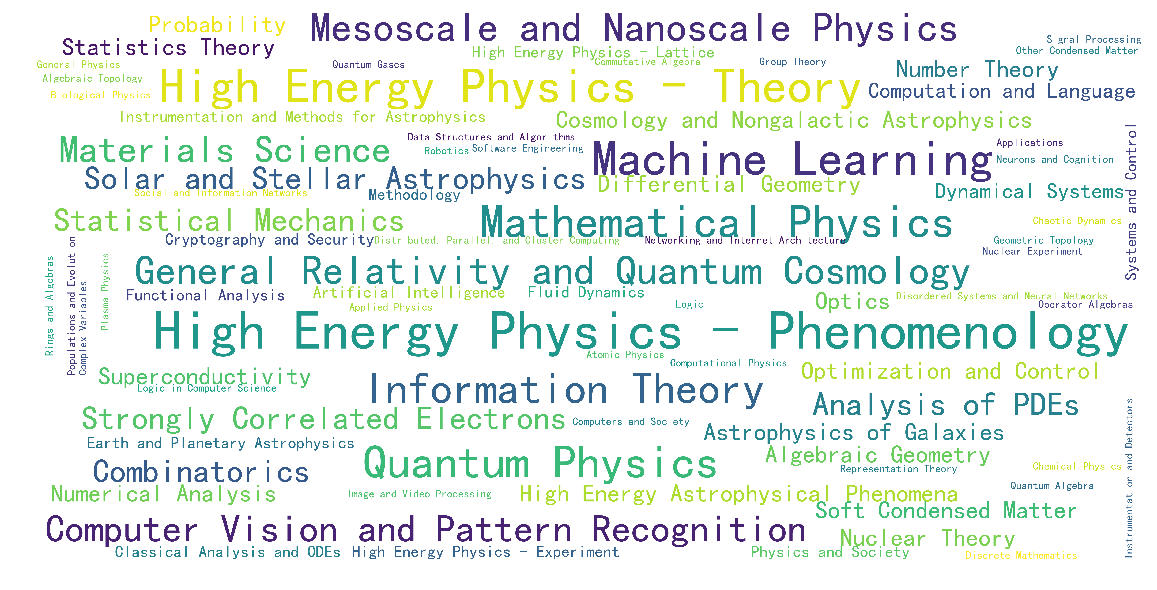

In [32]:
# 各子方向词云图
words = dataAllOneCtgr_countD.set_index('category_name').to_dict()["id"]
fig = plt.figure(figsize=(20, 20))
font='C:/Windows/Fonts/simhei.ttf'  #默认不支持中文
mycloud = WordCloud(font_path=font, background_color='white', scale=16).fit_words(words)
plt.imshow(mycloud)
plt.axis("off")  #隐藏坐标轴，不然巨丑
plt.show()

In [33]:
# 统计计算机子方向论文数量
group_name = "Computer Science"
cats = dataAllOneCtgr.query("group_name == @group_name")
dataAllOneCtgr_countCD = cats.groupby(["year","category_name"]).count().reset_index().pivot(index="year", columns="category_name",values="id") 

In [34]:
dataAllOneCtgr_countCD.head()

category_name,Artificial Intelligence,Computation and Language,Computational Complexity,"Computational Engineering, Finance, and Science",Computational Geometry,Computer Science and Game Theory,Computer Vision and Pattern Recognition,Computers and Society,Cryptography and Security,Data Structures and Algorithms,...,Operating Systems,Other Computer Science,Performance,Programming Languages,Robotics,Social and Information Networks,Software Engineering,Sound,Symbolic Computation,Systems and Control
year,,,,,,,,,,,,,,,,,,,,,
2008,149.0,717.0,153.0,29.0,65.0,74.0,50.0,43.0,125.0,179.0,...,14.0,186.0,19.0,36.0,51.0,NaN,89.0,3.0,52.0,NaN
2009,244.0,117.0,222.0,59.0,104.0,113.0,92.0,80.0,251.0,283.0,...,6.0,88.0,23.0,73.0,44.0,NaN,110.0,12.0,49.0,NaN
2010,303.0,68.0,230.0,87.0,129.0,146.0,223.0,76.0,320.0,335.0,...,18.0,167.0,29.0,105.0,40.0,57.0,158.0,17.0,67.0,15.0
2011,531.0,88.0,215.0,85.0,129.0,183.0,245.0,61.0,329.0,433.0,...,23.0,110.0,32.0,150.0,67.0,286.0,187.0,20.0,75.0,233.0
2012,696.0,151.0,266.0,140.0,179.0,289.0,375.0,128.0,472.0,524.0,...,15.0,186.0,38.0,118.0,92.0,495.0,285.0,16.0,55.0,297.0


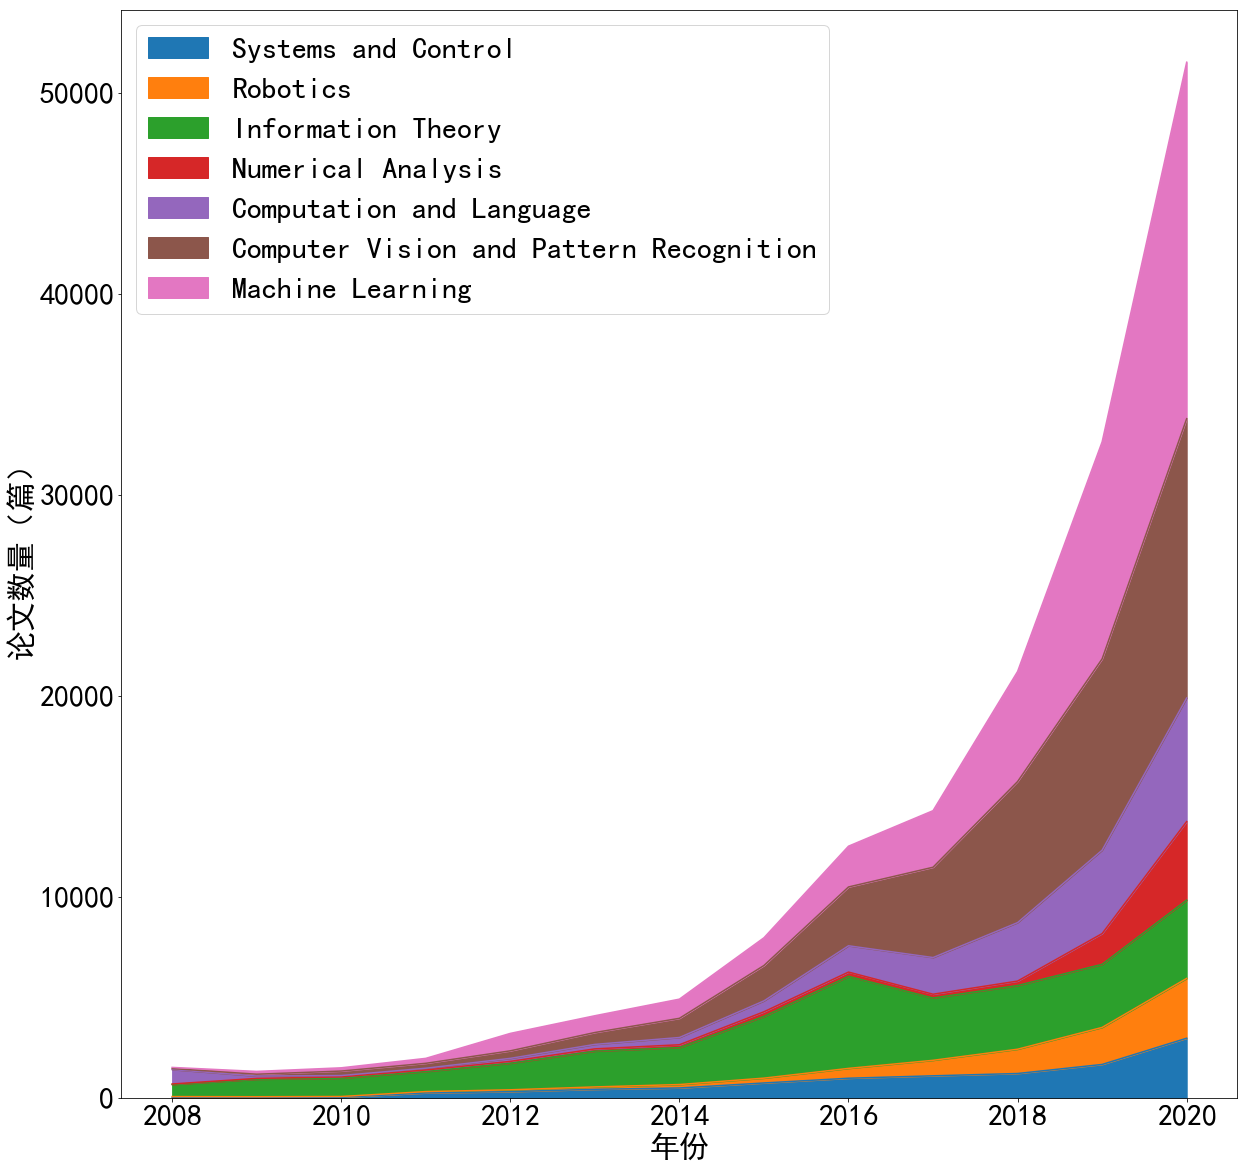

In [35]:
# 多柱状图表示计算机各方向3年论文数量
fig = plt.figure()
ax1  = fig.add_subplot(111)
listshow = ["Computer Vision and Pattern Recognition", "Machine Learning"]
dataAllOneCtgr_countCD[dataNearOneCtgr_countCD.index[-7:]].plot(kind='area', figsize=(20, 20), fontsize=30, ax=ax1)
ax1.set_ylabel('论文数量（篇）', fontsize=30)
ax1.set_xlabel('年份', fontsize=30)
plt.legend(fontsize=30)